Function and baseline TBPSA algorithm

=== TBPSA Baseline Runner ===
Dimension (default 5): 5
Budget evaluations (default 200): 2000
Random seed (default 0): 0
Plots saved in: tbpsa_baseline_out


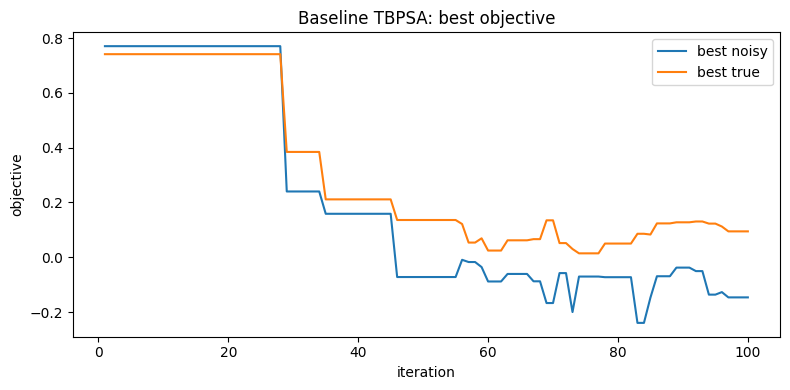

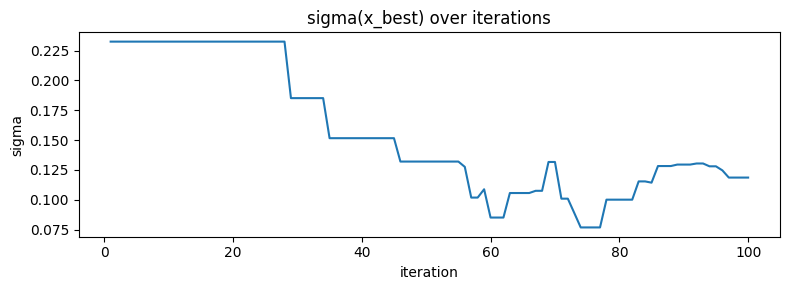

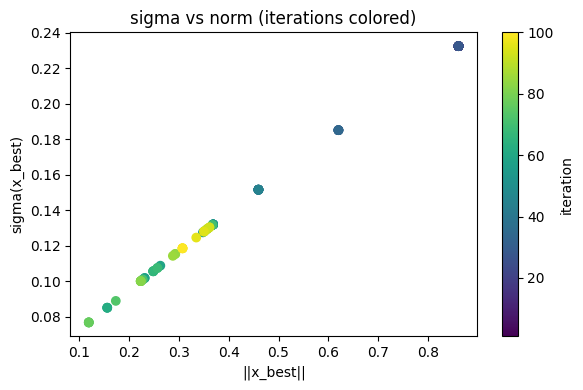

In [5]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

# ============================================================
# 1. Heteroskedastic quadratic (unchanged)
# ============================================================

class HeteroskedasticQuadratic:
    def __init__(
        self,
        dim: int,
        sigma_min: float = 0.05,
        sigma_max: float = 0.5,
        alpha: float = 0.5,
        seed: int | None = 0,
    ):
        assert dim >= 1
        self.dim = dim
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.alpha = alpha
        self.rng = np.random.default_rng(seed)

    def true_f(self, x: np.ndarray) -> float:
        x = np.asarray(x, float)
        return float(np.sum(x**2))

    def sigma_of_x(self, x: np.ndarray) -> float:
        r = float(np.linalg.norm(x))
        t = np.tanh(self.alpha * r)
        return self.sigma_min + (self.sigma_max - self.sigma_min) * t

    def noisy_f(self, x: np.ndarray, deterministic=False):
        sigma = self.sigma_of_x(x)
        if deterministic:
            return self.true_f(x), sigma
        noise = self.rng.normal(0.0, sigma)
        return self.true_f(x) + noise, sigma



# ============================================================
# 2. Proper TBPSA baseline
# ============================================================

def propose_candidates(x_center, n, step, rng):
    return rng.normal(loc=x_center, scale=step, size=(n, x_center.size))


def run_baseline(
    dim=5,
    budget=200,
    n_candidates=10,
    init_step=1.0,
    step_inc=1.05,
    step_dec=0.95,
    seed=0,
    out_dir="tbpsa_baseline_out",
):
    rng = np.random.default_rng(seed)
    prob = HeteroskedasticQuadratic(dim=dim, seed=seed)

    x_best = rng.normal(0.0, 1.0, size=(dim,))
    y_best_noisy, _ = prob.noisy_f(x_best)
    y_best_true, sigma_best = prob.noisy_f(x_best, deterministic=True)

    step = init_step
    evals = 0
    history = []

    while evals < budget:

        # -----------------------------------------
        # OLD SAMPLE: evaluate current point
        # -----------------------------------------
        old_vals = []
        for _ in range(n_candidates):
            y_old, _ = prob.noisy_f(x_best)
            old_vals.append(y_old)
            evals += 1
            if evals >= budget:
                break

        old_vals = np.array(old_vals)
        if evals >= budget:
            break

        # -----------------------------------------
        # NEW SAMPLE: evaluate new candidates
        # -----------------------------------------
        cand = propose_candidates(x_best, n_candidates, step, rng)
        new_vals = []
        new_trues = []
        new_sigmas = []

        for c in cand:
            y_noisy, sig = prob.noisy_f(c)
            y_true, _   = prob.noisy_f(c, deterministic=True)

            new_vals.append(y_noisy)
            new_trues.append(y_true)
            new_sigmas.append(sig)

            evals += 1
            if evals >= budget:
                break

        new_vals   = np.array(new_vals)
        new_trues  = np.array(new_trues)
        new_sigmas = np.array(new_sigmas)

        # -----------------------------------------
        # TBPSA TEST: compare medians
        # -----------------------------------------
        old_med = np.median(old_vals)
        new_med = np.median(new_vals)

        if new_med < old_med:
            idx = int(np.argmin(new_vals))
            x_best = cand[idx]
            y_best_noisy = new_vals[idx]
            y_best_true  = new_trues[idx]
            sigma_best   = new_sigmas[idx]
            step *= step_inc  # enlarge exploration

        elif new_med > old_med:
            step *= step_dec  # shrink exploration

        # equal → do nothing

        # -----------------------------------------
        # LOG HISTORY
        # -----------------------------------------
        history.append({
            "evals": evals,
            "x_best": x_best.copy(),
            "noisy_best": float(y_best_noisy),
            "true_best": float(y_best_true),
            "sigma_best": float(sigma_best),
            "step": float(step),
        })


    # ============================================================
    # SAVE RESULTS (same as your version)
    # ============================================================

    os.makedirs(out_dir, exist_ok=True)

    with open(f"{out_dir}/history.csv", "w", newline="") as fh:
        writer = csv.writer(fh)
        writer.writerow(["iter", "evals", "noisy_best", "true_best",
                         "sigma_best", "step", "x_best"])
        for i, rec in enumerate(history, 1):
            writer.writerow([
                i,
                rec["evals"],
                rec["noisy_best"],
                rec["true_best"],
                rec["sigma_best"],
                rec["step"],
                "|".join(f"{v:.6g}" for v in rec["x_best"]),
            ])

    # ============================================================
    # PLOTS
    # ============================================================

    iters = np.arange(1, len(history) + 1)
    noisy_vals = [h["noisy_best"] for h in history]
    true_vals  = [h["true_best"] for h in history]
    sigma_vals = [h["sigma_best"] for h in history]
    norms      = [float(np.linalg.norm(h["x_best"])) for h in history]

    # Plot 1
    plt.figure(figsize=(8, 4))
    plt.plot(iters, noisy_vals, label="best noisy")
    plt.plot(iters, true_vals,  label="best true")
    plt.xlabel("iteration"); plt.ylabel("objective")
    plt.title("Baseline TBPSA: best objective")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{out_dir}/best_values.png")

    # Plot 2
    plt.figure(figsize=(8, 3))
    plt.plot(iters, sigma_vals)
    plt.xlabel("iteration"); plt.ylabel("sigma")
    plt.title("sigma(x_best) over iterations")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/sigma_over_iters.png")

    # Plot 3
    plt.figure(figsize=(6, 4))
    plt.scatter(norms, sigma_vals, c=iters, cmap="viridis")
    plt.xlabel("||x_best||"); plt.ylabel("sigma(x_best)")
    plt.title("sigma vs norm (iterations colored)")
    plt.colorbar(label="iteration")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/sigma_vs_norm.png")

    print("Plots saved in:", out_dir)



# ============================================================
# 3. USER INPUT — dynamic, like your original
# ============================================================

if __name__ == "__main__":
    print("=== TBPSA Baseline Runner ===")
    dim = int(input("Dimension (default 5): ") or 5)
    budget = int(input("Budget evaluations (default 200): ") or 200)
    seed = int(input("Random seed (default 0): ") or 0)

    run_baseline(dim=dim, budget=budget, seed=seed)




Sigma aware algorithm

=== Sigma-aware TBPSA (Task 3) ===
Dimension (default 5): 5
Budget evaluations (default 200): 2000
Random seed (default 0): 0
Sigma-aware results saved in: tbpsa_sigma_weighted_out


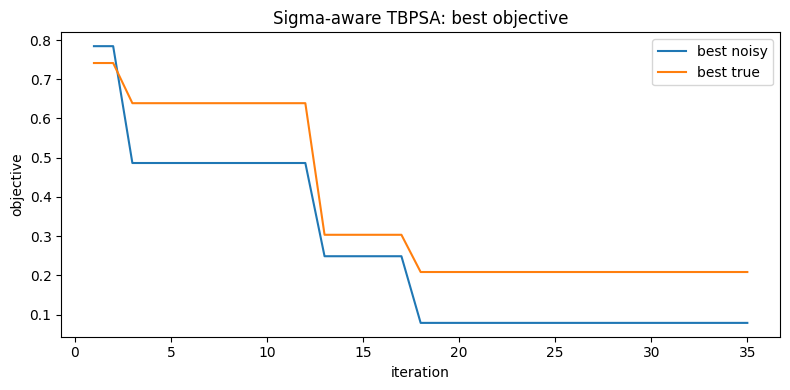

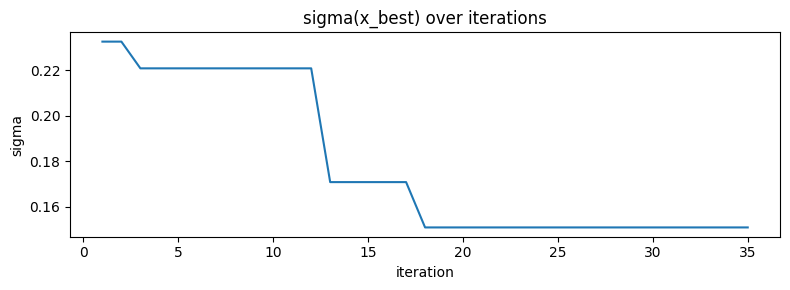

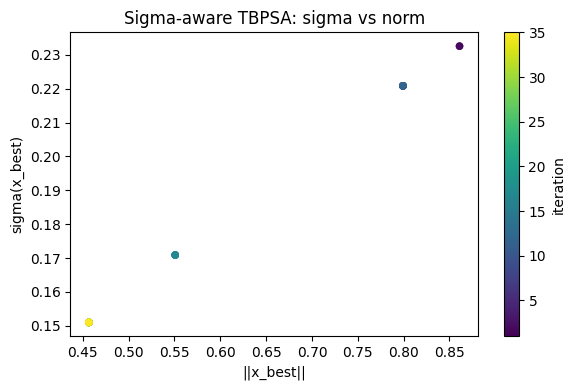

In [6]:
from __future__ import annotations
import numpy as np
import csv, os
import matplotlib.pyplot as plt

# ============================================================
#  Heteroskedastic quadratic (copied directly, Colab-friendly)
# ============================================================

class HeteroskedasticQuadratic:
    def __init__(self, dim, sigma_min=0.05, sigma_max=0.5, alpha=0.5, seed=0):
        self.dim = dim
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.alpha = alpha
        self.rng = np.random.default_rng(seed)

    def true_f(self, x):
        return float(np.sum(np.asarray(x) ** 2))

    def sigma_of_x(self, x):
        r = float(np.linalg.norm(np.asarray(x)))
        t = np.tanh(self.alpha * r)
        return self.sigma_min + (self.sigma_max - self.sigma_min) * t

    def noisy_f(self, x, deterministic=False):
        sigma = self.sigma_of_x(x)
        if deterministic:
            return self.true_f(x), sigma
        noise = self.rng.normal(0, sigma)
        return self.true_f(x) + noise, sigma


# ============================================================
#  Candidates (same as Task 2)
# ============================================================

def propose_candidates(x_center, n, step, rng):
    return rng.normal(loc=x_center, scale=step, size=(n, x_center.size))


# ============================================================
#  Sigma-aware evaluation with RESAMPLING (Step 3)
# ============================================================

def evaluate_sigma_aware(prob, x):
    _, sigma = prob.noisy_f(x, deterministic=True)

    if sigma < 0.1:
        k = 1
    elif sigma < 0.2:
        k = 2
    elif sigma < 0.3:
        k = 4
    else:
        k = 6

    vals = [prob.noisy_f(x)[0] for _ in range(k)]
    return float(np.mean(vals)), sigma, k


# ============================================================
#  SIGMA-AWARE TBPSA (Task 3)
# ============================================================

def run_sigma_aware(
    dim=5,
    budget=200,
    n_candidates=10,
    init_step=1.0,
    step_decay=0.995,
    seed=0,
):
    rng = np.random.default_rng(seed)
    prob = HeteroskedasticQuadratic(dim=dim, seed=seed)

    x_best = rng.normal(0.0, 1.0, size=(dim,))
    y_best, sigma_best, _ = evaluate_sigma_aware(prob, x_best)
    true_best, _ = prob.noisy_f(x_best, deterministic=True)

    history = []
    evals = 0
    step = init_step

    while evals < budget:
        cand = propose_candidates(x_best, n_candidates, step, rng)

        for c in cand:
            y_mean, sigma, k = evaluate_sigma_aware(prob, c)
            y_true, _ = prob.noisy_f(c, deterministic=True)

            evals += k
            if evals >= budget:
                break

            if y_mean < y_best:
                x_best = c
                y_best = y_mean
                sigma_best = sigma
                true_best = y_true

        history.append({
            "evals": evals,
            "x_best": x_best.copy(),
            "noisy_best": float(y_best),
            "true_best": float(true_best),
            "sigma_best": float(sigma_best),
            "step": float(step),
        })

        step *= step_decay

    return history


# ============================================================
#  MAIN (dynamic input, perfect for Google Colab)
# ============================================================

if __name__ == "__main__":
    print("=== Sigma-aware TBPSA (Task 3) ===")

    dim = int(input("Dimension (default 5): ") or 5)
    budget = int(input("Budget evaluations (default 200): ") or 200)
    seed = int(input("Random seed (default 0): ") or 0)

    history = run_sigma_aware(dim=dim, budget=budget, seed=seed)

    out_dir = "tbpsa_sigma_weighted_out"
    os.makedirs(out_dir, exist_ok=True)

    # SAVE CSV
    with open(f"{out_dir}/history.csv", "w", newline="") as fh:
        writer = csv.writer(fh)
        writer.writerow(
            ["iter", "evals", "noisy_best", "true_best",
             "sigma_best", "x_best"]
        )
        for i, rec in enumerate(history, 1):
            writer.writerow([
                i,
                rec["evals"],
                rec["noisy_best"],
                rec["true_best"],
                rec["sigma_best"],
                "|".join(f"{v:.6g}" for v in rec["x_best"]),
            ])

    # PLOTS — same as Task 2
    iters = np.arange(1, len(history) + 1)
    noisy_vals = [h["noisy_best"] for h in history]
    true_vals  = [h["true_best"] for h in history]
    sigma_vals = [h["sigma_best"] for h in history]
    norms      = [np.linalg.norm(h["x_best"]) for h in history]

    # PLOT 1
    plt.figure(figsize=(8,4))
    plt.plot(iters, noisy_vals, label="best noisy")
    plt.plot(iters, true_vals, label="best true")
    plt.xlabel("iteration")
    plt.ylabel("objective")
    plt.title("Sigma-aware TBPSA: best objective")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{out_dir}/best_values.png")

    # PLOT 2
    plt.figure(figsize=(8,3))
    plt.plot(iters, sigma_vals)
    plt.xlabel("iteration")
    plt.ylabel("sigma")
    plt.title("sigma(x_best) over iterations")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/sigma_over_iters.png")

    # PLOT 3
    plt.figure(figsize=(6,4))
    plt.scatter(norms, sigma_vals, c=iters, cmap="viridis", s=20)
    plt.xlabel("||x_best||")
    plt.ylabel("sigma(x_best)")
    plt.title("Sigma-aware TBPSA: sigma vs norm")
    plt.colorbar(label="iteration")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/sigma_vs_norm.png")

    print("Sigma-aware results saved in:", out_dir)

Performing experiments

In [ ]:
# ============================================
#  TEXT BLOCK 3: Batch experiment runner
#  Runs BASELINE + SIGMA-AWARE for several seeds
#  100% compatible with Colab (no external imports)
# ============================================

import os
import csv
import numpy as np

def save_history_csv(history, out_dir):
    """Save a sigma-aware history list into a CSV file."""
    os.makedirs(out_dir, exist_ok=True)
    csv_path = os.path.join(out_dir, "history.csv")

    with open(csv_path, "w", newline="") as fh:
        writer = csv.writer(fh)
        writer.writerow(
            ["iter", "evals", "noisy_best", "true_best",
             "sigma_best", "step", "x_best"]
        )
        for i, rec in enumerate(history, start=1):
            writer.writerow([
                i,
                rec["evals"],
                rec["noisy_best"],
                rec["true_best"],
                rec["sigma_best"],
                rec.get("step", None),
                "|".join(f"{v:.6g}" for v in rec["x_best"]),
            ])

    print(f"Saved {csv_path}")


def run_batch_experiments():
    print("=== Batch experiments for TBPSA (Colab version) ===")

    # ----------------------------
    # USER INPUTS
    # ----------------------------
    dim = int(input("Dimension (default 5): ") or 5)
    budget = int(input("Budget evaluations (default 200): ") or 200)
    n_seeds = int(input("How many seeds? (default 5): ") or 5)

    seeds = list(range(n_seeds))



    print("\nAll batch experiments completed.")


# ----------------------------------------------------------
# Entry point for running the batch
# ----------------------------------------------------------
if __name__ == "__main__":
    run_batch_experiments()


=== Batch experiments for TBPSA (Colab version) ===
Dimension (default 5): 5
Budget evaluations (default 200): 2000
How many seeds? (default 5): 5

All batch experiments completed.


Analysis blocks

In [ ]:
# ==========================================
# Cell 1: imports + load all experiment CSVs
# ==========================================

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (6, 4)

# In Colab, assumiamo che il notebook si trovi nella root
# dove hai le cartelle:
#   tbpsa_baseline_out_seed0/
#   tbpsa_baseline_out_seed1/
#   ...
#   tbpsa_sigma_weighted_out_seed0/
#   ...

base_dir = Path(".")   # current working directory
print("Current working directory:", base_dir.resolve())

all_runs = []

# ---- Load BASELINE runs ----
for path in base_dir.glob("tbpsa_baseline_out_seed*/history.csv"):
    df = pd.read_csv(path)
    seed = int(path.parent.name.split("seed")[-1])
    df["algo"] = "baseline"
    df["seed"] = seed

    # ensure 'step' exists
    if "step" not in df.columns:
        df["step"] = None

    all_runs.append(df)
    print("Loaded BASELINE:", path)

# ---- Load SIGMA-AWARE runs ----
for path in base_dir.glob("tbpsa_sigma_weighted_out_seed*/history.csv"):
    df = pd.read_csv(path)
    seed = int(path.parent.name.split("seed")[-1])
    df["algo"] = "sigma-aware"
    df["seed"] = seed

    # sigma-aware CSV might not have 'step'
    if "step" not in df.columns:
        df["step"] = None

    all_runs.append(df)
    print("Loaded SIGMA-AWARE:", path)

# ---- Error if no CSVs were found ----
if not all_runs:
    raise RuntimeError(
        "❌ No history.csv files found.\n"
        "Make sure you uploaded the folders or cloned your repo in Colab."
    )

# ---- Merge into a single table ----
results = pd.concat(all_runs, ignore_index=True)
print("\nLoaded a total of:", len(results), "rows")
results.head()


Current working directory: /content
Loaded BASELINE: tbpsa_baseline_out_seed4/history.csv
Loaded BASELINE: tbpsa_baseline_out_seed3/history.csv
Loaded BASELINE: tbpsa_baseline_out_seed1/history.csv
Loaded BASELINE: tbpsa_baseline_out_seed2/history.csv
Loaded BASELINE: tbpsa_baseline_out_seed0/history.csv
Loaded SIGMA-AWARE: tbpsa_sigma_weighted_out_seed2/history.csv
Loaded SIGMA-AWARE: tbpsa_sigma_weighted_out_seed3/history.csv
Loaded SIGMA-AWARE: tbpsa_sigma_weighted_out_seed1/history.csv
Loaded SIGMA-AWARE: tbpsa_sigma_weighted_out_seed4/history.csv
Loaded SIGMA-AWARE: tbpsa_sigma_weighted_out_seed0/history.csv

Loaded a total of: 1175 rows


,iter,evals,noisy_best,true_best,sigma_best,step,x_best,algo,seed
0,1,10,4.298756,4.205212,0.397413,1.000000,-0.940516|0.28386|0.71065|0.290521|-1.62808,baseline,4
1,2,20,4.298756,4.205212,0.397413,0.995000,-0.940516|0.28386|0.71065|0.290521|-1.62808,baseline,4
2,3,30,1.630343,2.350990,0.340239,0.990025,-0.858509|-0.568637|0.431136|0.244421|-1.02224,baseline,4
3,4,40,1.127973,1.411919,0.289784,0.985075,0.675635|0.453595|0.310376|-0.122418|-0.798979,baseline,4
4,5,50,0.773976,0.920446,0.250701,0.980150,-0.0637647|0.462659|0.211049|-0.165224|-0.794031,baseline,4


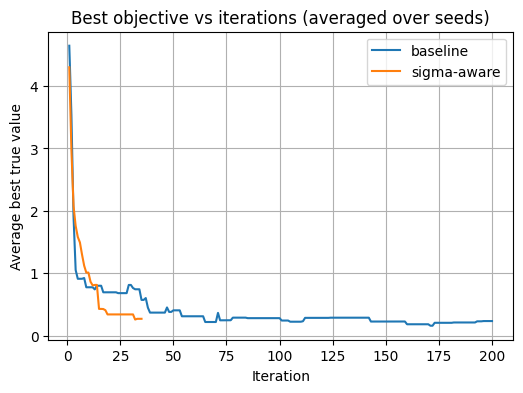

In [ ]:
# Cell 2: average best true objective vs iteration for each algorithm

# Group by algorithm and iteration, average the true_best value
avg_curve = (
    results
    .groupby(["algo", "iter"])["true_best"]
    .mean()
    .reset_index()
)

plt.figure()
for algo, df_algo in avg_curve.groupby("algo"):
    plt.plot(df_algo["iter"], df_algo["true_best"], label=algo)

plt.xlabel("Iteration")
plt.ylabel("Average best true value")
plt.title("Best objective vs iterations (averaged over seeds)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-216047967.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


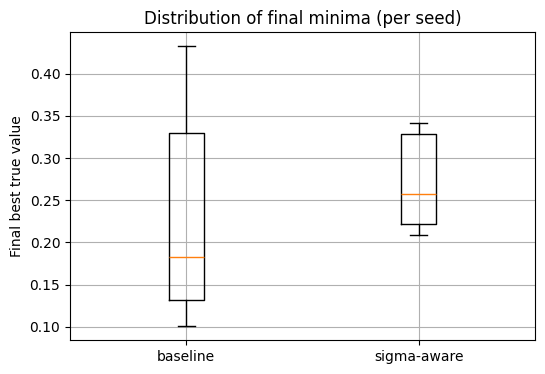

(count    5.000000
 mean     0.235143
 std      0.140949
 min      0.100625
 25%      0.131228
 50%      0.182126
 75%      0.329436
 max      0.432301
 Name: true_best, dtype: float64,
 count    5.000000
 mean     0.271336
 std      0.060767
 min      0.208463
 25%      0.221576
 50%      0.257140
 75%      0.327797
 max      0.341706
 Name: true_best, dtype: float64)

In [ ]:
# Cell 3: distribution of final best true value per algorithm

# Take the last recorded row for each (algo, seed) run
last_points = (
    results
    .groupby(["algo", "seed"])
    .tail(1)
    .reset_index(drop=True)
)

baseline_final = last_points[last_points["algo"] == "baseline"]["true_best"]
sigma_final    = last_points[last_points["algo"] == "sigma-aware"]["true_best"]

plt.figure()
plt.boxplot(
    [baseline_final, sigma_final],
    labels=["baseline", "sigma-aware"],
)
plt.ylabel("Final best true value")
plt.title("Distribution of final minima (per seed)")
plt.grid(True)
plt.show()

baseline_final.describe(), sigma_final.describe()

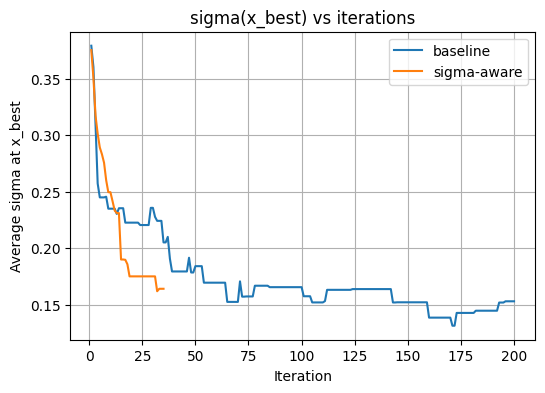

In [ ]:
# Cell 4: how sigma at x_best evolves (averaged across seeds)

avg_sigma = (
    results
    .groupby(["algo", "iter"])["sigma_best"]
    .mean()
    .reset_index()
)

plt.figure()
for algo, df_algo in avg_sigma.groupby("algo"):
    plt.plot(df_algo["iter"], df_algo["sigma_best"], label=algo)

plt.xlabel("Iteration")
plt.ylabel("Average sigma at x_best")
plt.title("sigma(x_best) vs iterations")
plt.legend()
plt.grid(True)
plt.show()